In [83]:
import sys
from astropy import units as un, constants as cons
from astropy.cosmology import Planck18 as cosmo
import numpy as np
import scipy.interpolate
from latexify import latexify
from matplotlib import pyplot as plt
import cmasher as cmr
from astropy.visualization import quantity_support
quantity_support()

sys.path.append('../pysrc/')
import solve_ode as CF
import HaloPotential_new as Halo
import WiersmaCooling as Cool

import importlib

In [38]:
# Cosmology
print(cosmo)
rho_crit = cosmo.critical_density0
rho_mean = cosmo.Om0*rho_crit
delta_c =  18 * np.pi**2 + 82 * (cosmo.Om0 - 1) - 39 * (cosmo.Om0 - 1)**2 #Bryan & Norman 98

mu = 0.62 

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)


In [39]:
# Helper function for dervied values
def calc_r_vir(M_vir):
    r_vir = np.power(M_vir / (4/3) / np.pi / delta_c / rho_crit, 1/3)
    return r_vir.to('kpc')

def calc_r_200_c(M_vir):
    r_vir = np.power(M_vir / (4/3) / np.pi / 200 / rho_crit, 1/3)
    return r_vir.to('kpc')
    
def calc_r_200_m(M_vir):
    r_vir = np.power(M_vir / (4/3) / np.pi / 200 / rho_mean, 1/3)
    return r_vir.to('kpc')

def calc_T_vir(M_vir):
    r_vir = calc_r_vir(M_vir)
    vc = np.sqrt(cons.G * M_vir / r_vir)
    temp = mu*cons.m_p*vc**2/cons.k_B/2
    return temp.to('K')

def calc_concentration(M_vir):
    h = cosmo.H0.value/100
    M_ref = 1e12/h * un.Msun
    log_c = 0.905 - 0.101*np.log10(M_vir/M_ref)
    return np.power(10, log_c)

def circular_temp(vc):
    temp = 0.6*mu*cons.m_p*vc**2/cons.k_B
    return temp.to('K')

In [40]:
# Parameters
M_vir = 1e11 * un.Msun
r_vir = calc_r_vir(M_vir)
T_vir = calc_T_vir(M_vir)
c_vir = calc_concentration(M_vir) # Concentration parameter
r_200_m = calc_r_200_m(M_vir)
r_200_c = calc_r_200_c(M_vir)
M_gal = 1e10 * un.Msun # Greco et al 2012 for M82
r_gal = 0.015*r_200_c # Kravtsoc 2013 expression for stellar half-mass radius
z_gal = 0.15 * un.kpc # Lim et al 2013 for M82
      
print("Halo Mass: ",M_vir)
print("Virial Radius: ", r_vir)
print("Virial Temperature: ", T_vir)
print("Concentration Parameter: ", c_vir)
print("R200m: ", r_200_m)
print("R200c: ", r_200_c)
print("Disk Mass", M_gal)
print("Disk Scale Radius", r_gal)
print("Disk Scale Height", z_gal)

nfw = Halo.NFWPotential(M_vir, r_vir, c_vir)
plummer = Halo.PlummerPotential(M_gal, r_gal)
outer = Halo.OuterHaloPotential(rho_mean, r_200_m)
combined = Halo.CombinedPotential(M_vir, r_vir, c_vir, M_gal, r_gal, rho_mean, r_200_m)

Halo Mass:  100000000000.0 solMass
Virial Radius:  122.40315626626357 kpc
Virial Temperature:  131960.7175211719 K
Concentration Parameter:  10.54718269190388
R200m:  144.76736317842207 kpc
R200c:  97.94126310709676 kpc
Disk Mass 10000000000.0 solMass
Disk Scale Radius 1.4691189466064514 kpc
Disk Scale Height 0.15 kpc


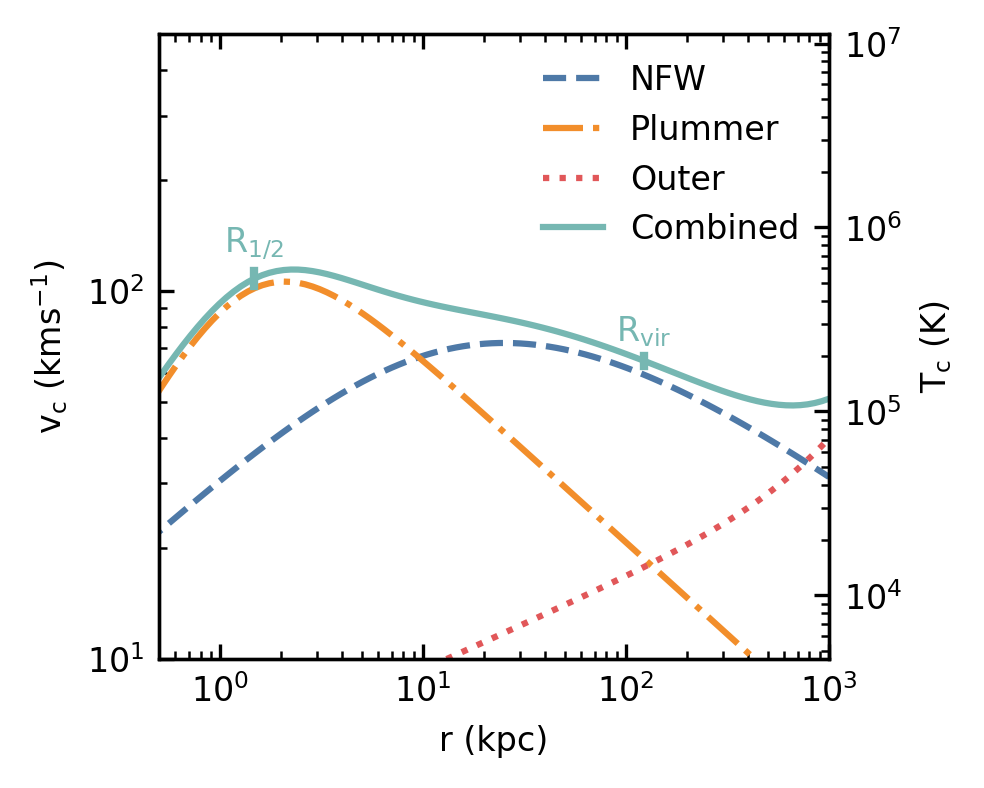

In [41]:
# Plot the circular velocity and its components
rs = np.logspace(-0.5,3,100) * un.kpc

cvs = nfw.vc(rs)
p_cvs = plummer.vc(rs)
o_cvs = outer.vc(rs)
c_cvs = combined.vc(rs)

latexify(columns=1)
plt.figure()
ax=plt.gca()
ax.tick_params(top=True, right=True, which="both", direction='in')
plt.yscale('log')
plt.xscale('log')
plt.xlim(0.5,1000)
plt.ylim(10,500)

plt.plot(rs,cvs,ls='--',label="NFW")
plt.plot(rs,p_cvs,ls='-.',label="Plummer")
plt.plot(rs,o_cvs,ls=':',label="Outer")
plt.plot(rs,c_cvs,ls='-',label="Combined")

tick_length = 2
ticks = [r_vir,r_200_m,r_200_c,r_gal]
tick_labels = [r'R$_{\rm vir}$', r'R$_{\rm 200m}$', r'R$_{\rm 200c}$', r'R$_{\rm 1/2}$']
label_dirs = [-3,1,1,1]

tick_length = 2
plt.plot([r_vir.value,r_vir.value], 
         [combined.vc(r_vir).value - tick_length, combined.vc(r_vir).value + tick_length], 
         color="C3", lw=2)
plt.text(r_vir.value,combined.vc(r_vir).value + tick_length * 2.5, r'R$_{\rm vir}$',
         color="C3", ha='center', va='bottom')

tick_length = 5
plt.plot([r_gal.value,r_gal.value], 
         [combined.vc(r_gal).value - tick_length, combined.vc(r_gal).value + tick_length], 
         color="C3", lw=2)
plt.text(r_gal.value,combined.vc(r_gal).value + tick_length * 2.5, r'R$_{\rm 1/2}$',
         color="C3", ha='center', va='bottom')

plt.xlabel('r (kpc)')
plt.ylabel(r'v$_{\rm c}$ (kms$^{-1}$)')
plt.legend(frameon=False, handlelength=1.8)

ax2 = ax.twinx() 
ax2.tick_params(which="both", direction='in')
ax2.set_yscale('log')
ax2.set_ylabel(r'T$_{\rm c}$ (K)') 
ax2.set_ylim(circular_temp(10*un.km/un.s),circular_temp(500*un.km/un.s))

plt.tight_layout()
plt.savefig('./plots/v_circ.pdf',dpi=150)
plt.show()

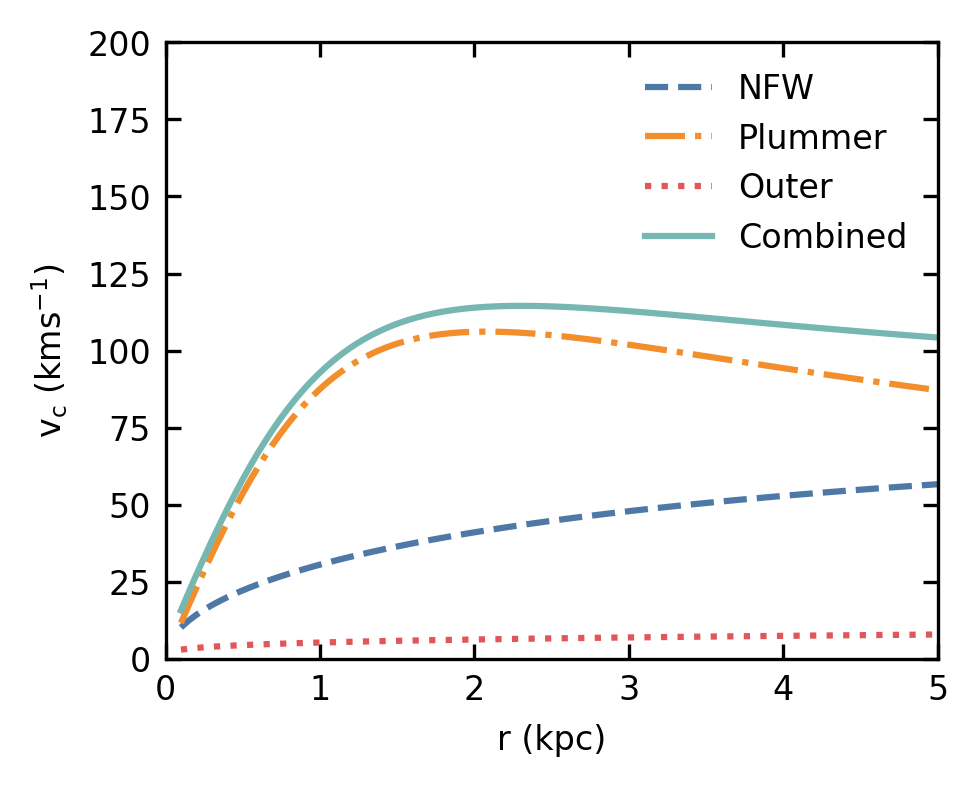

In [42]:
# Plot the circular velocity and its components
# This is in the inner region to compare with observed rotation curves in Greco et al 2012 for M82
# The main difference is we are using a R1/2 that is larger by about a factor of 2
rs = np.linspace(0.1,5,100) * un.kpc

cvs = nfw.vc(rs)
p_cvs = plummer.vc(rs)
o_cvs = outer.vc(rs)
c_cvs = combined.vc(rs)

latexify(columns=1)
plt.figure()
ax=plt.gca()
ax.tick_params(top=True, right=True, which="both", direction='in')
plt.xlim(0,5)
plt.ylim(0,200)

plt.plot(rs,cvs,ls='--',label="NFW")
plt.plot(rs,p_cvs,ls='-.',label="Plummer")
plt.plot(rs,o_cvs,ls=':',label="Outer")
plt.plot(rs,c_cvs,ls='-',label="Combined")

plt.xlabel('r (kpc)')
plt.ylabel(r'v$_{\rm c}$ (kms$^{-1}$)')
plt.legend(frameon = False)

plt.show()

In [43]:
# # Check that dlnvc/dlnr has been implemented correctly 
# latexify(columns=2)
# plt.figure()

# plt.plot(rs,(rs.value/cvs.value)*np.gradient(cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
# plt.plot(rs,nfw.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

# plt.plot(rs,(rs.value/p_cvs.value)*np.gradient(p_cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
# plt.plot(rs,plummer.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

# plt.plot(rs,(rs.value/o_cvs.value)*np.gradient(o_cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
# plt.plot(rs,outer.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

# plt.plot(rs,(rs.value/c_cvs.value)*np.gradient(c_cvs.value,rs.value),alpha=0.5,label='(r/vc)*dvc/dr')
# plt.plot(rs,combined.dlnvc_dlnR(rs),alpha=0.5,ls='--',label='From Class Method')

# plt.ylabel('dlnvc/dlnr')
# plt.legend(frameon=False, ncols=2)
# plt.xscale('log')
# plt.xlim(0.5,1000)
# plt.ylim(-0.6,0.8)
# plt.show()

In [44]:
# Set Cooling
cooling = Cool.Wiersma_Cooling(Z2Zsun=1/3,z=0)

/mnt/home/btan1/Work/CGM_ICs/ipynb/../pysrc/WiersmaCooling.py:53: RuntimeWarning: invalid value encountered in log10
  vals = log(self.LAMBDA(X*un.K,Y*un.cm**-3).value)


In [80]:
# importlib.reload(CF)
max_step = 0.1                         #lowest resolution of solution in ln(r)
R_min    = 1*un.kpc                  #inner radius of supersonic part of solution
R_max    = 5.*combined.r_vir          #outer radius of integration
R_sonics  = np.linspace(2,30,10)*un.kpc  #sonic radii
transsonic_solutions = []
for R_sonic in R_sonics:
    print('R_sonic = %s'%R_sonic)
    transsonic_solutions.append(CF.shoot_from_R_sonic(combined,
                                                          cooling,
                                                          R_sonic,
                                                          R_max,
                                                          R_min,
                                                          max_step=max_step,
                                                          verbose=False))
                        

R_sonic = 2.0 kpc
No result reached R_max. Set return_all_results=True to check intermediate solutions.
R_sonic = 5.111111111111111 kpc
No result reached R_max. Set return_all_results=True to check intermediate solutions.
R_sonic = 8.222222222222221 kpc
R_sonic = 11.333333333333334 kpc
R_sonic = 14.444444444444445 kpc
R_sonic = 17.555555555555557 kpc
R_sonic = 20.666666666666668 kpc
R_sonic = 23.77777777777778 kpc


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/astropy/units/quantity.py:611: RuntimeWarning: overflow encountered in square
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


R_sonic = 26.88888888888889 kpc
R_sonic = 30.0 kpc


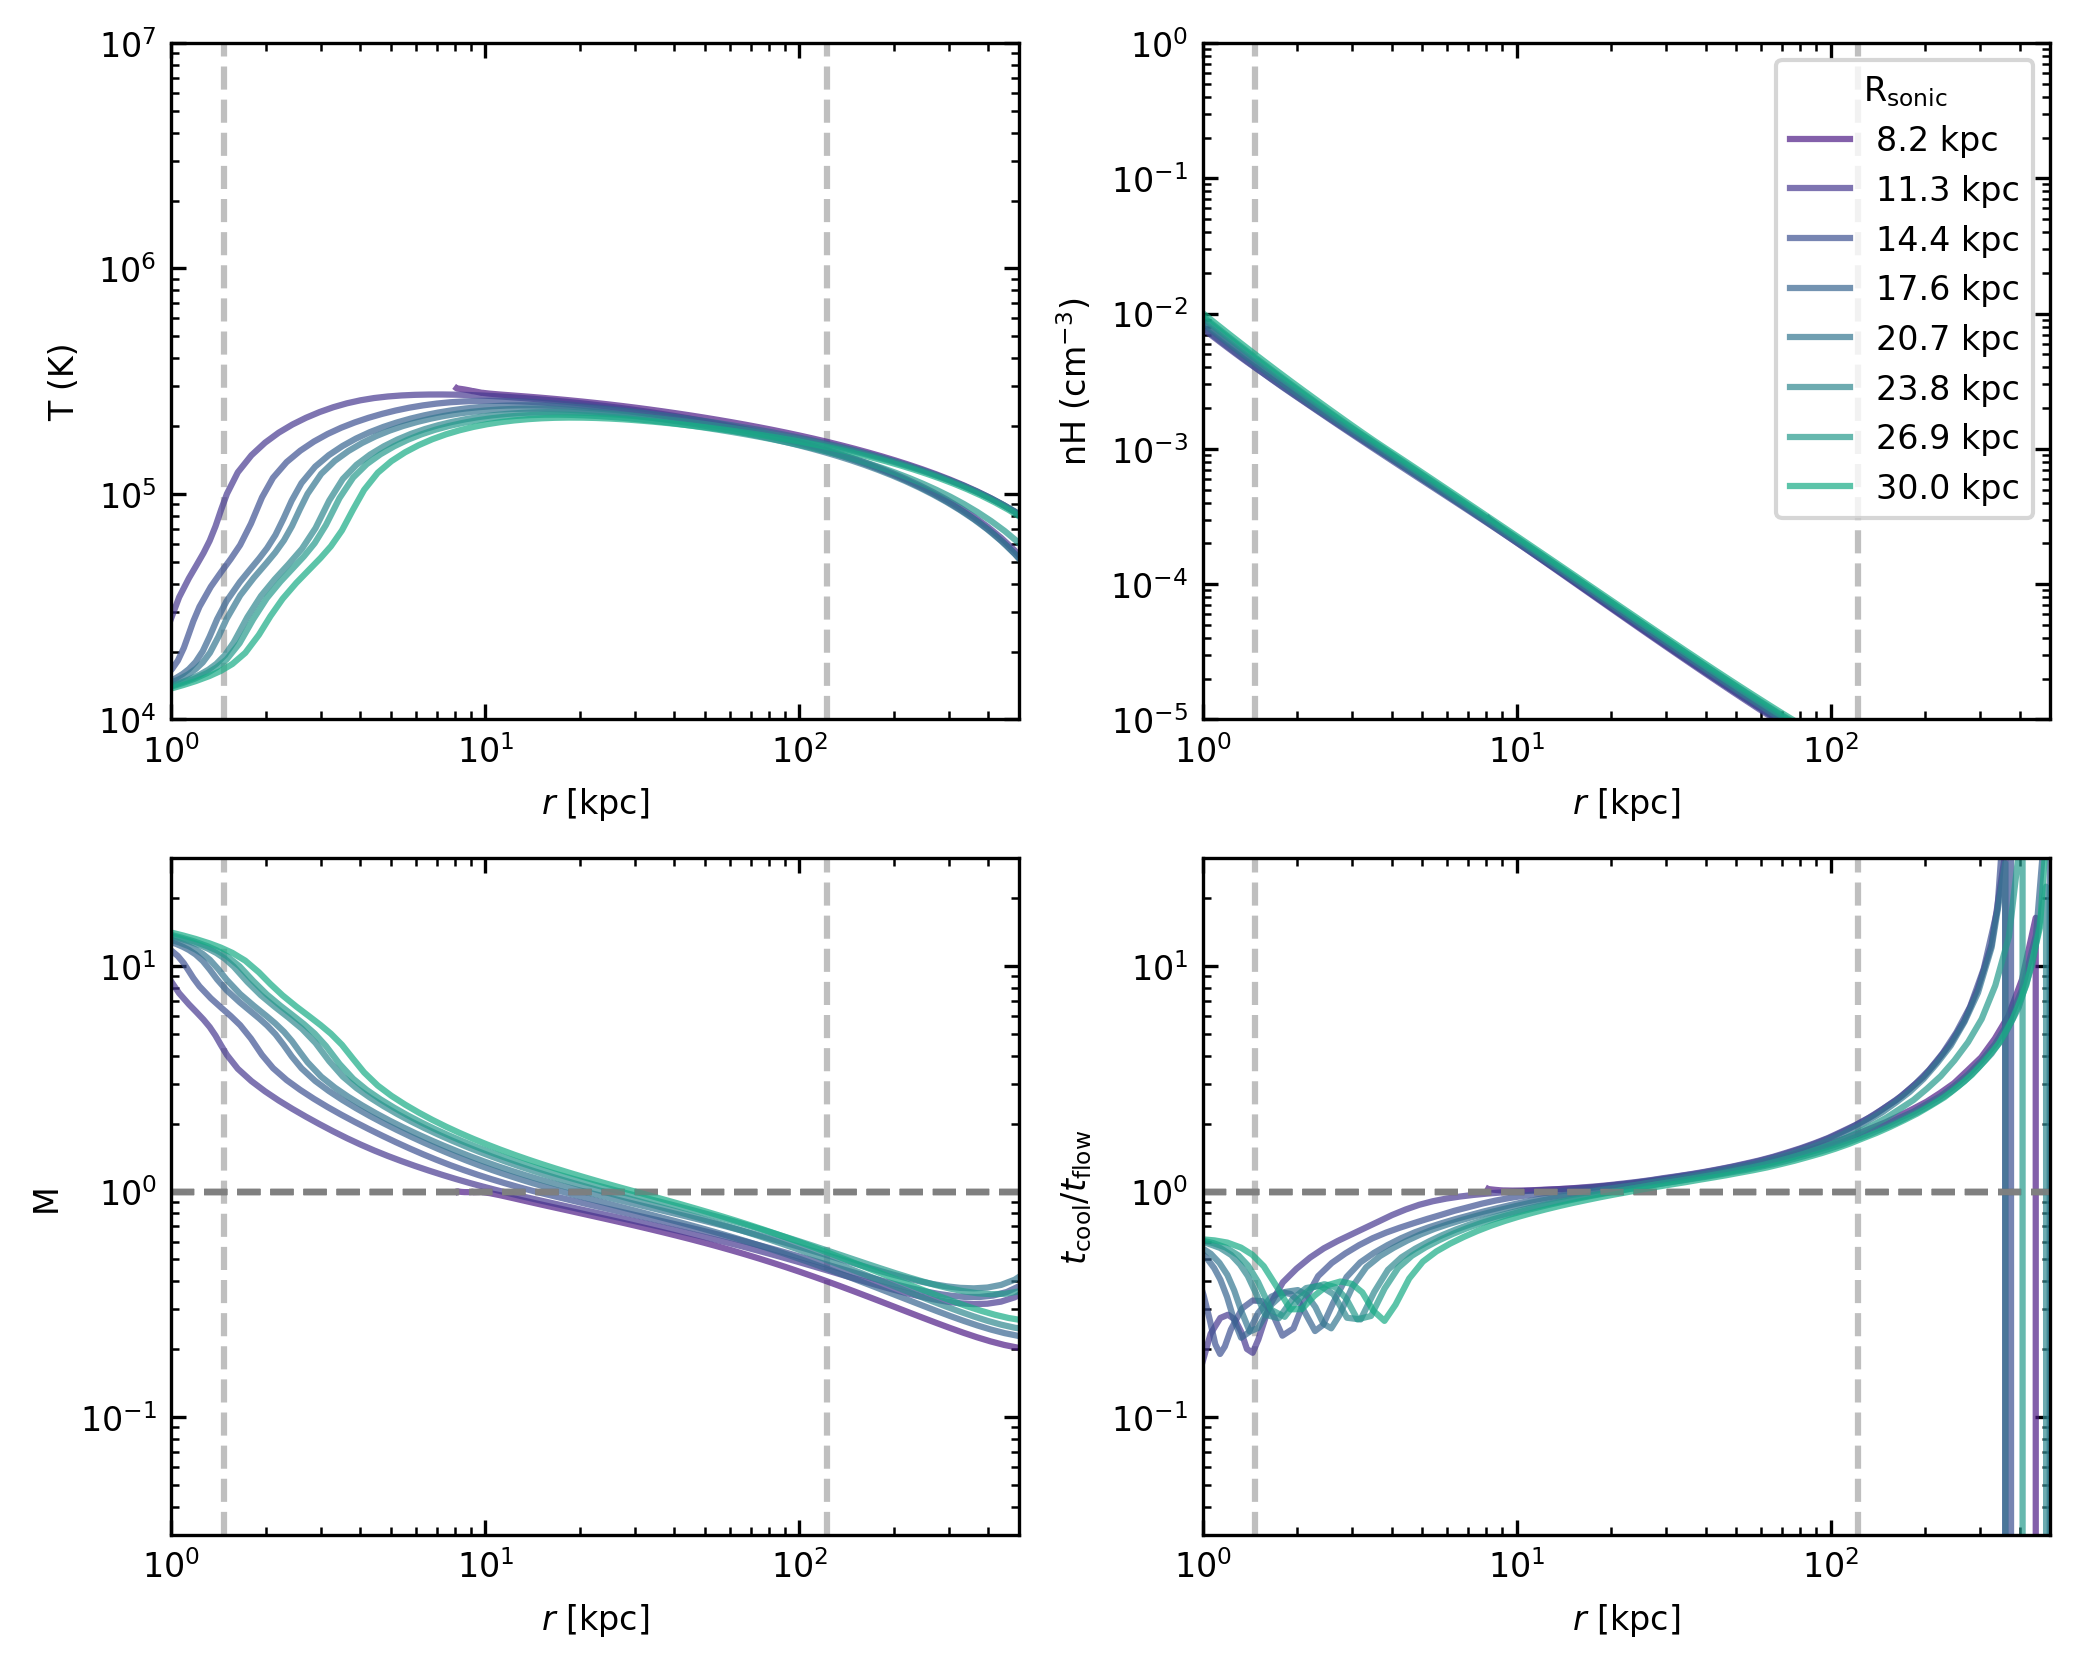

In [121]:
latexify(columns=2)
fig, axs = plt.subplots(2, 2)

for ax in axs.flatten():
    ax.set_xlabel(r'$r$ [kpc]')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(top=True, right=True, which="both", direction='in')
    ax.set_xlim(1,500)

    ax.axvline(r_gal,c='.5',ls='--',alpha=0.5)
    ax.axvline(r_vir,c='.5',ls='--',alpha=0.5)

colors = cmr.lavender(np.linspace(0.2,0.8,len(transsonic_solutions)))
for i in range(len(transsonic_solutions)):
    res = transsonic_solutions[i]
    if res is not None:
        axs[0, 0].plot(res.Rs, res.Ts, alpha=0.7, color=colors[i])
        axs[0, 0].set_ylabel(r'T (K)')
        axs[0, 0].set_ylim(1e4,1e7)
        
        axs[0, 1].plot(res.Rs, res.nHs, alpha=0.7, color=colors[i], label=f'{R_sonics[i].value:.1f} kpc')
        axs[0, 1].set_ylabel(r'nH (cm$^{-3}$)')
        axs[0, 1].set_ylim(1e-5,1)
        
        axs[1, 0].plot(res.Rs, res.Ms, alpha=0.7, color=colors[i])
        axs[1, 0].set_ylabel(r'M')
        axs[1, 0].set_ylim(0.03,30)
        axs[1, 0].axhline(1.,c='.5',ls='--',alpha=0.5)
        
        axs[1, 1].plot(res.Rs, res.t_cools / res.t_flows, alpha=0.7, color=colors[i])
        axs[1, 1].set_ylabel(r'$t_{\rm cool}/t_{\rm flow}$')
        axs[1, 1].set_ylim(0.03,30)
        axs[1, 1].axhline(1.,c='.5',ls='--',alpha=0.5)

axs[0, 1].legend(frameon=True, loc='upper right', title=r'R$_{\rm sonic}$', handlelength=1.8)
plt.tight_layout()
plt.savefig('./plots/cf_sols.pdf',dpi=150)
plt.show()